In [18]:
!pip install -q ultralytics==8.3.0

In [20]:
from ultralytics import YOLO
from pathlib import Path
import shutil, random, os, json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [21]:
DATA_ROOT = Path(r"C:/Users/costas/OneDrive/Desktop/MEng PROJECT/outputs_yolo/switches_yolo")

train_img = DATA_ROOT / "images/train"
train_lab = DATA_ROOT / "labels/train"
val_img   = DATA_ROOT / "images/val"
val_lab   = DATA_ROOT / "labels/val"
val_img.mkdir(parents=True, exist_ok=True)
val_lab.mkdir(parents=True, exist_ok=True)

imgs = sorted(train_img.glob("*.png"))
random.seed(42)
val_take = max(1, int(0.2 * len(imgs)))  # ~20%
val_set = set(random.sample(imgs, val_take))

moved = 0
for img_path in imgs:
    stem = img_path.stem
    lab_path = train_lab / f"{stem}.txt"
    if img_path in val_set and lab_path.exists():
        shutil.move(str(img_path), val_img / img_path.name)
        shutil.move(str(lab_path), val_lab / lab_path.name)
        moved += 1
moved


20

In [23]:
yaml_text = f"""
path: {DATA_ROOT.as_posix()}
train: images/train
val: images/val
names:
  0: good_switch
  1: bad_switch
"""
(DATA_ROOT / "switches.yaml").write_text(yaml_text)
print((DATA_ROOT / "switches.yaml").read_text())



path: C:/Users/costas/OneDrive/Desktop/MEng PROJECT/outputs_yolo/switches_yolo
train: images/train
val: images/val
names:
  0: good_switch
  1: bad_switch



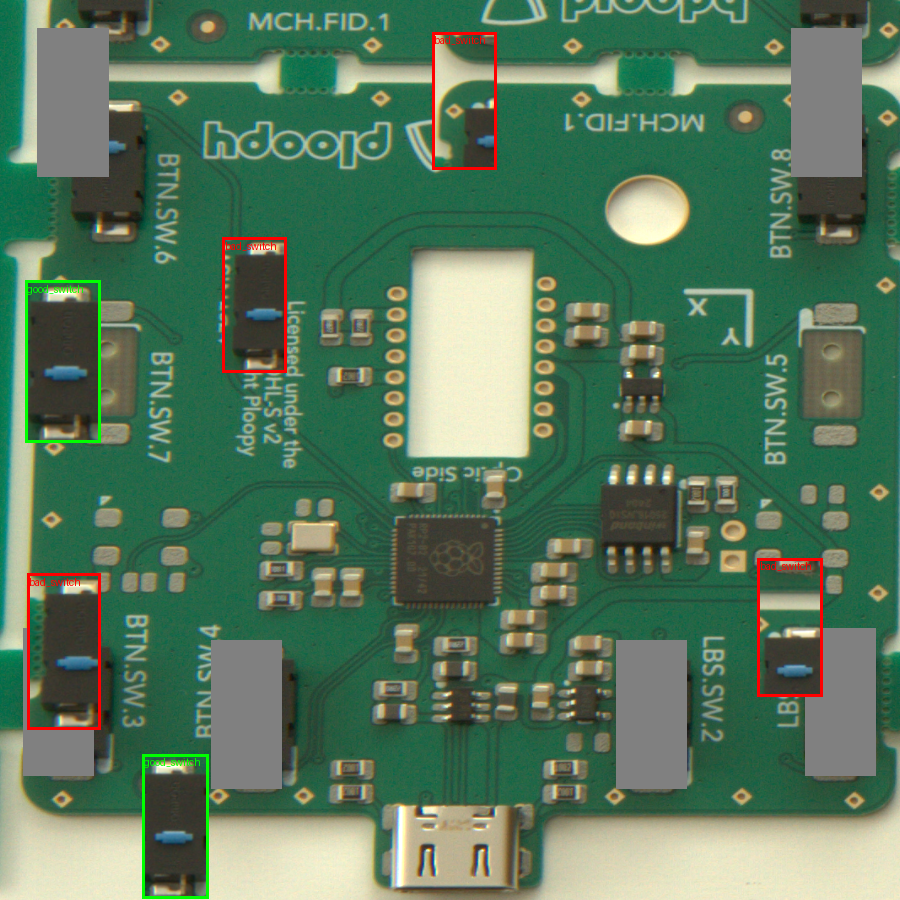

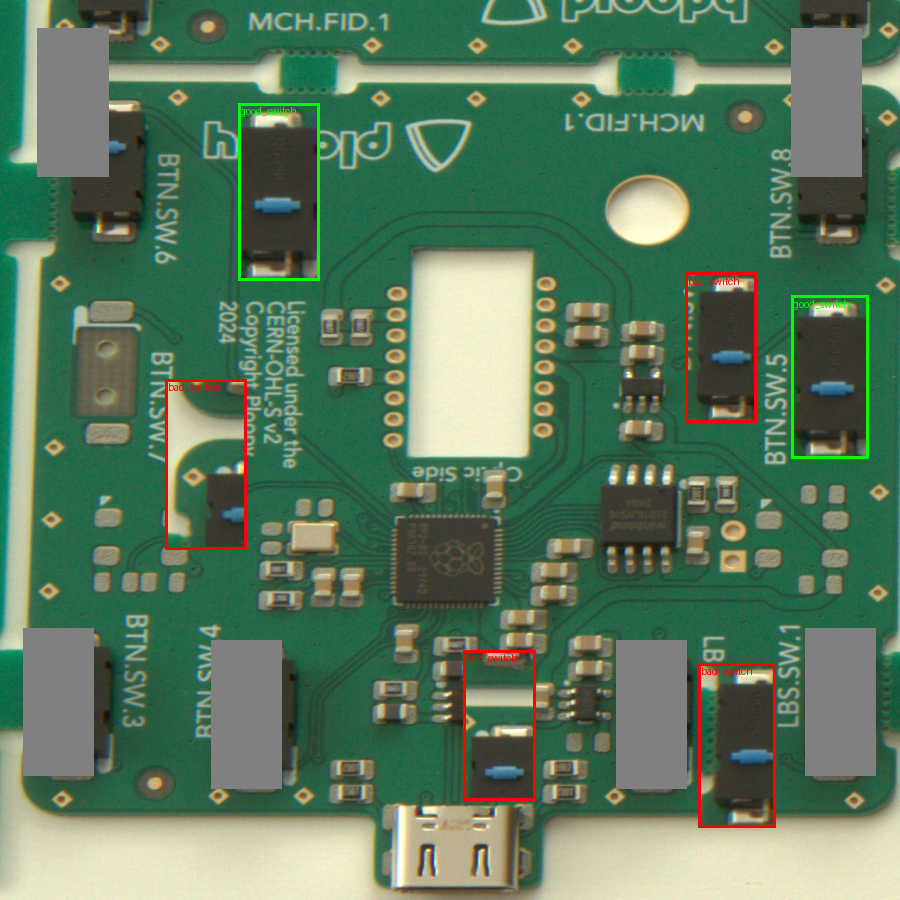

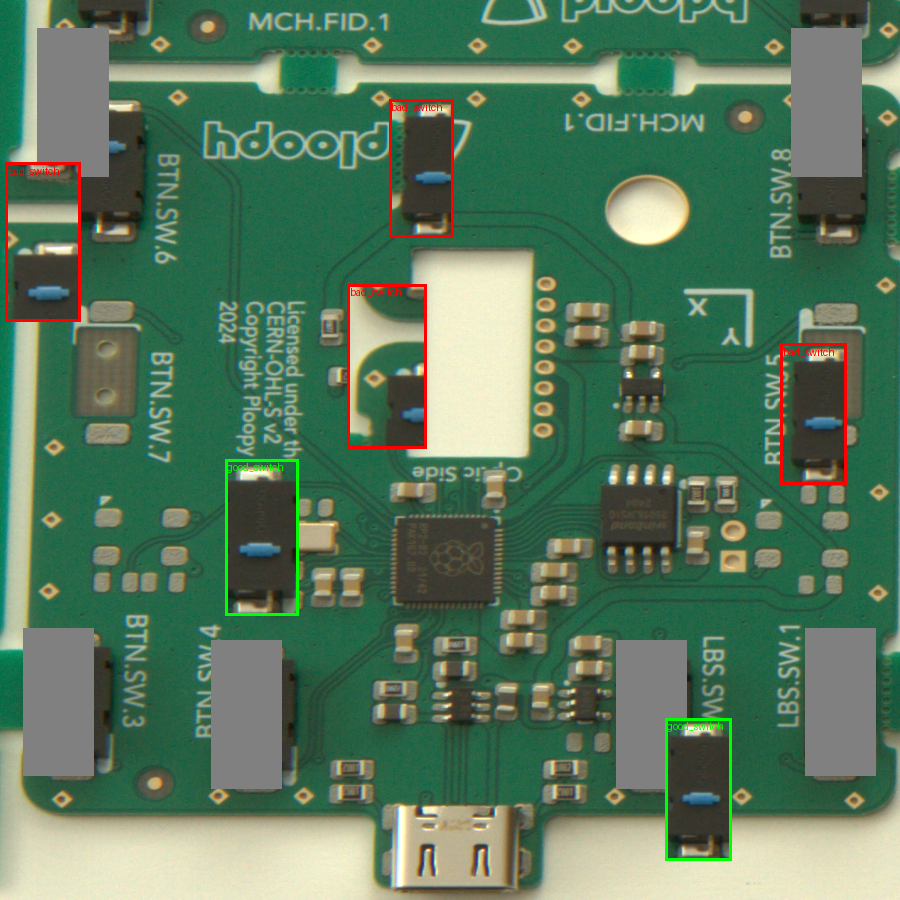

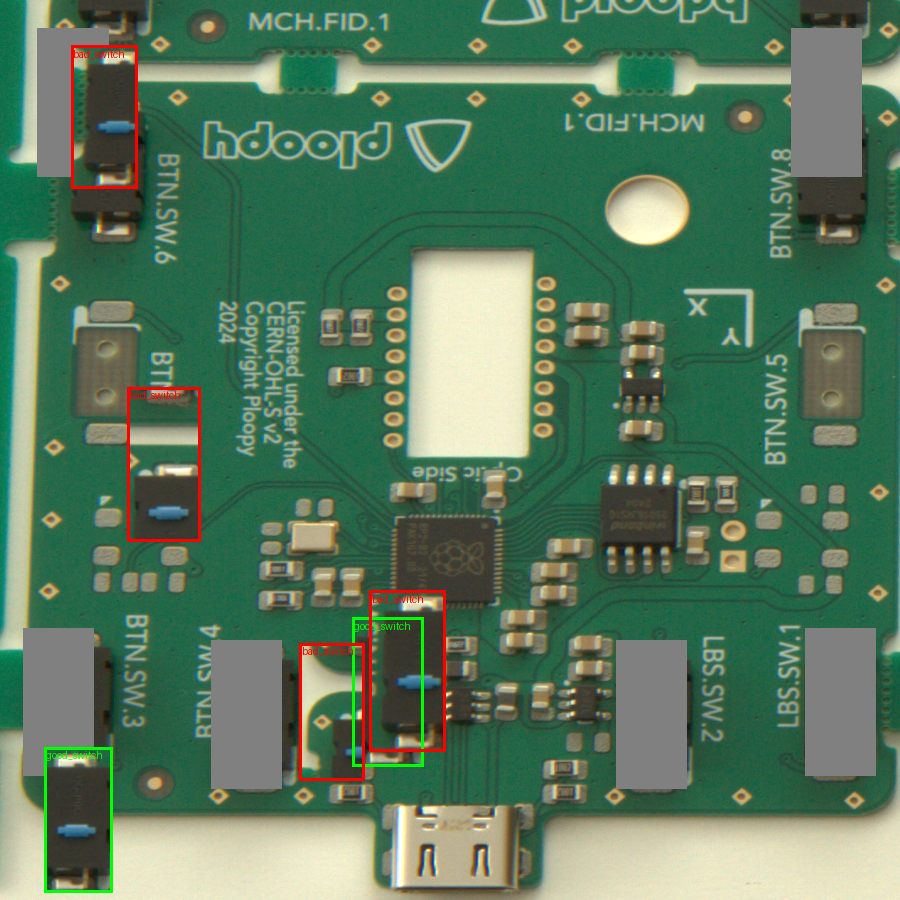

In [6]:
def draw_yolo_boxes(img_path, lab_path, names):
    im = Image.open(img_path).convert("RGB")
    W, H = im.size
    draw = ImageDraw.Draw(im)
    if not lab_path.exists():
        return im
    for line in lab_path.read_text().strip().splitlines():
        if not line.strip(): continue
        cid, cx, cy, w, h = line.split()
        cid = int(cid); cx=float(cx); cy=float(cy); w=float(w); h=float(h)
        x0 = (cx - w/2) * W; y0 = (cy - h/2) * H
        x1 = (cx + w/2) * W; y1 = (cy + h/2) * H
        color = (0,255,0) if cid==0 else (255,0,0)  # green good, red bad
        draw.rectangle([x0,y0,x1,y1], outline=color, width=3)
        draw.text((x0+2, y0+2), names[cid], fill=color)
    return im

CLASS_NAMES = {0: "good_switch", 1: "bad_switch"}
sample_imgs = list((DATA_ROOT / "images/train").glob("*.png"))[:2] + list((DATA_ROOT / "images/val").glob("*.png"))[:2]

for p in sample_imgs:
    im = draw_yolo_boxes(p, DATA_ROOT / "labels" / p.parent.name / f"{p.stem}.txt", CLASS_NAMES)
    display(im)


In [15]:
from ultralytics import YOLO
from pathlib import Path

model = YOLO("yolov8n.pt")

results = model.train(
    data=str(DATA_ROOT / "switches.yaml"),
    epochs=100,
    imgsz=896,
    batch=8,
    lr0=0.005,
    patience=30,
    mosaic=1.0,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=5.0, translate=0.08, scale=0.15, shear=2.0, flipud=0.0, fliplr=0.5,
    name="switches_yolov8n_balanced"
)


New https://pypi.org/project/ultralytics/8.3.185 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.9 torch-2.5.1+cu121 CPU (13th Gen Intel Core(TM) i9-13900K)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\costas\OneDrive\Desktop\MEng PROJECT\outputs_yolo\switches_yolo\switches.yaml, epochs=100, time=None, patience=30, batch=8, imgsz=896, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=switches_yolov8n_balanced, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, ag

train: Scanning C:\Users\costas\OneDrive\Desktop\MEng PROJECT\outputs_yolo\switches_yolo\labels\train... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1093.59it/s]

train: New cache created: C:\Users\costas\OneDrive\Desktop\MEng PROJECT\outputs_yolo\switches_yolo\labels\train.cache



val: Scanning C:\Users\costas\OneDrive\Desktop\MEng PROJECT\outputs_yolo\switches_yolo\labels\val.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

Plotting labels to runs\detect\switches_yolov8n_balanced\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
Image sizes 896 train, 896 val
Using 0 dataloader workers
Logging results to runs\detect\switches_yolov8n_balanced
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.259      3.388      1.367         38        896: 100%|██████████| 13/13 [00:30<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

                   all         36        216     0.0149      0.892       0.22      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G     0.9134      2.764      1.063         30        896: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

                   all         36        216     0.0159       0.93      0.542      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G     0.8005      2.131     0.9865         35        896: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

                   all         36        216     0.0163      0.943       0.63      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G     0.7768      1.601     0.9583         31        896: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

                   all         36        216      0.017      0.943      0.683      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.8007      1.427     0.9684         30        896: 100%|██████████| 13/13 [00:28<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

                   all         36        216      0.946      0.214      0.694      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.7545      1.322     0.9438         25        896: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

                   all         36        216      0.936      0.183       0.71      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.7393      1.221     0.9427         26        896: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]

                   all         36        216       0.95      0.332      0.729      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.6729      1.129     0.9183         27        896: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

                   all         36        216      0.775      0.273       0.55      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.7121       1.16     0.9289         24        896: 100%|██████████| 13/13 [00:33<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

                   all         36        216      0.673      0.411      0.577      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.6456      1.065     0.9054         24        896: 100%|██████████| 13/13 [00:32<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

                   all         36        216      0.612      0.522      0.558      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.6326      1.006     0.9006         34        896: 100%|██████████| 13/13 [00:31<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

                   all         36        216      0.763      0.714      0.784      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.6277     0.9699     0.8948         25        896: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

                   all         36        216       0.66      0.734      0.806      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.6664     0.9807     0.9115         25        896: 100%|██████████| 13/13 [00:26<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

                   all         36        216      0.801      0.693      0.784      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.6215     0.8984     0.8923         37        896: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

                   all         36        216      0.839      0.702      0.765      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.5795     0.8797     0.8867         27        896: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

                   all         36        216      0.852      0.745      0.811      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.5864     0.8414     0.8813         25        896: 100%|██████████| 13/13 [00:36<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

                   all         36        216      0.863      0.744      0.818      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.5231     0.7755      0.864         35        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

                   all         36        216       0.81       0.79      0.821      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.5346      0.787     0.8723         31        896: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

                   all         36        216      0.848      0.771      0.781      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      0.522     0.7566     0.8717         23        896: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

                   all         36        216      0.697      0.825       0.78      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.5204     0.7673     0.8736         22        896: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

                   all         36        216      0.738      0.819      0.799      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.5045     0.6821     0.8639         29        896: 100%|██████████| 13/13 [00:28<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

                   all         36        216      0.743      0.833       0.82      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.4901     0.6847     0.8559         29        896: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

                   all         36        216      0.729      0.858      0.785      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.4728     0.6663     0.8539         33        896: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

                   all         36        216      0.779      0.843      0.841      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      0.457      0.625     0.8518         31        896: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

                   all         36        216      0.891      0.794      0.858      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.4235     0.6097     0.8481         30        896: 100%|██████████| 13/13 [00:28<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

                   all         36        216      0.923      0.766      0.823      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G     0.4428     0.6016     0.8493         31        896: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

                   all         36        216      0.944      0.773      0.816      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.4536     0.5999     0.8552         30        896: 100%|██████████| 13/13 [00:33<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

                   all         36        216      0.888      0.763      0.783      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.4593     0.6077     0.8547         32        896: 100%|██████████| 13/13 [00:31<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

                   all         36        216      0.865      0.748      0.806      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.4577     0.5796      0.847         29        896: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

                   all         36        216      0.753      0.764       0.81      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.4148     0.5683     0.8344         39        896: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

                   all         36        216      0.736      0.859       0.81      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.4466     0.5665     0.8481         28        896: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

                   all         36        216      0.791      0.812      0.829      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.4101     0.5483     0.8389         34        896: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

                   all         36        216      0.842      0.797      0.841      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.4275     0.5775     0.8446         35        896: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

                   all         36        216      0.843      0.781       0.79       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.4185     0.5461     0.8495         32        896: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

                   all         36        216      0.846      0.771      0.785      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.4327     0.5498     0.8483         27        896: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

                   all         36        216      0.795      0.801      0.817      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.4023     0.5427     0.8352         40        896: 100%|██████████| 13/13 [00:33<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

                   all         36        216      0.875      0.771      0.844      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.3915      0.536     0.8364         34        896: 100%|██████████| 13/13 [00:33<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

                   all         36        216      0.906      0.803      0.858      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      0.402     0.5249       0.84         27        896: 100%|██████████| 13/13 [00:32<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

                   all         36        216      0.834       0.88      0.926      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.3913     0.5039     0.8339         33        896: 100%|██████████| 13/13 [00:34<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

                   all         36        216        0.9      0.849      0.903      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.3824     0.5035     0.8317         28        896: 100%|██████████| 13/13 [00:33<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

                   all         36        216      0.878      0.845      0.869      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.3988     0.4989     0.8351         28        896: 100%|██████████| 13/13 [00:33<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

                   all         36        216      0.844      0.891      0.905      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.3915     0.4982     0.8443         30        896: 100%|██████████| 13/13 [00:34<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

                   all         36        216      0.843      0.887      0.903      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.3805     0.4935     0.8381         36        896: 100%|██████████| 13/13 [00:33<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

                   all         36        216       0.83      0.798      0.875      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.3614     0.4719     0.8297         28        896: 100%|██████████| 13/13 [00:34<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

                   all         36        216      0.856      0.792      0.832      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.3648     0.4834     0.8344         29        896: 100%|██████████| 13/13 [00:33<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

                   all         36        216      0.855      0.793      0.828      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.3955     0.4991     0.8365         28        896: 100%|██████████| 13/13 [00:33<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

                   all         36        216      0.843      0.828      0.876      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.3697     0.4635     0.8365         23        896: 100%|██████████| 13/13 [00:33<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

                   all         36        216      0.882      0.786       0.87      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.3529     0.4313     0.8324         28        896: 100%|██████████| 13/13 [00:33<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

                   all         36        216      0.887       0.79      0.854      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.3395     0.4388     0.8216         23        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

                   all         36        216       0.81      0.812      0.833      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.3353     0.4392     0.8317         33        896: 100%|██████████| 13/13 [00:33<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all         36        216      0.825      0.809      0.837      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.3472     0.4355     0.8265         25        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all         36        216      0.856      0.778       0.85      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.3455     0.4153     0.8309         26        896: 100%|██████████| 13/13 [00:33<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

                   all         36        216      0.836      0.829      0.862      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.3586     0.4227     0.8292         34        896: 100%|██████████| 13/13 [00:33<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

                   all         36        216       0.82      0.825      0.862      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.3362     0.4164     0.8233         23        896: 100%|██████████| 13/13 [00:33<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

                   all         36        216      0.791      0.846      0.841      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.3421     0.4258     0.8274         40        896: 100%|██████████| 13/13 [00:33<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all         36        216      0.805      0.823      0.828      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.3136     0.3988      0.821         29        896: 100%|██████████| 13/13 [00:33<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

                   all         36        216      0.782      0.831      0.829      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.3416     0.4192     0.8266         30        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

                   all         36        216      0.821      0.797      0.819      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.3254     0.4038     0.8256         26        896: 100%|██████████| 13/13 [00:32<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all         36        216      0.814      0.801       0.82      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.3208     0.3845      0.818         29        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

                   all         36        216      0.832      0.785      0.814      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.3294     0.3917     0.8188         24        896: 100%|██████████| 13/13 [00:33<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

                   all         36        216      0.865      0.776      0.816      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.3157     0.3924     0.8213         31        896: 100%|██████████| 13/13 [00:32<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

                   all         36        216       0.85      0.779      0.817      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      0.302     0.3792     0.8219         27        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

                   all         36        216      0.853      0.764      0.819      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.3133     0.3753     0.8187         38        896: 100%|██████████| 13/13 [00:33<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

                   all         36        216      0.849      0.772      0.816      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      0.325     0.3803     0.8211         32        896: 100%|██████████| 13/13 [00:34<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

                   all         36        216      0.873      0.773      0.815      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.3114     0.3777     0.8211         26        896: 100%|██████████| 13/13 [00:33<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

                   all         36        216      0.837      0.777       0.81      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.3109     0.3816     0.8236         24        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all         36        216      0.835      0.775      0.816      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.3093     0.3735     0.8125         31        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

                   all         36        216      0.831       0.78      0.823      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.3002     0.3617     0.8181         34        896: 100%|██████████| 13/13 [00:33<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all         36        216      0.828      0.803       0.83      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      0.308     0.3706     0.8263         22        896: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

                   all         36        216      0.851      0.776      0.821      0.764
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 39, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



69 epochs completed in 0.704 hours.
Optimizer stripped from runs\detect\switches_yolov8n_balanced\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\switches_yolov8n_balanced\weights\best.pt, 5.7MB

Validating runs\detect\switches_yolov8n_balanced\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.9 torch-2.5.1+cu121 CPU (13th Gen Intel Core(TM) i9-13900K)
Model summary (fused): 186 layers, 2,684,758 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


                   all         36        216      0.899      0.849      0.903      0.843
           good_switch         12         31      0.841      0.774      0.836      0.801
            bad_switch         36        185      0.956      0.924      0.969      0.885
Speed: 2.9ms preprocess, 96.9ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\switches_yolov8n_balanced


In [26]:
# Run prediction on a random new image
from ultralytics import YOLO
from matplotlib import pyplot as plt

# load your trained weights
model = YOLO(r"C:\Users\costas\OneDrive\Desktop\MEng PROJECT\runs\detect\switches_yolov8n_balanced\weights\best.pt")

# run inference
img_path = r"C:\Users\costas\OneDrive\Desktop\MEng PROJECT\images\test2.png"
res_list = model.predict(
    source=img_path,
    imgsz=896,        # match training size
    conf=0.4,        # you can tune this
    iou=0.2,
    save=True,        # saves annotated image
    project=r"C:\Users\costas\OneDrive\Desktop\MEng PROJECT\outputs_yolo",
    name="pred_random"
)

# get first result
res = res_list[0]

# inline display in Jupyter
im_bgr = res.plot()
plt.figure(figsize=(10,10))
plt.imshow(im_bgr[..., ::-1])   # convert BGR→RGB
plt.axis("off"); plt.show()

print("Saved annotated image to:", res.save_dir)


image 1/1 C:\Users\costas\OneDrive\Desktop\MEng PROJECT\images\test2.png: 896x864 2 good_switchs, 4 bad_switchs, 54.6ms
Speed: 4.1ms preprocess, 54.6ms inference, 4.6ms postprocess per image at shape (1, 3, 896, 864)
Results saved to C:\Users\costas\OneDrive\Desktop\MEng PROJECT\outputs_yolo\pred_random8


<Figure size 1000x1000 with 1 Axes>

Saved annotated image to: C:\Users\costas\OneDrive\Desktop\MEng PROJECT\outputs_yolo\pred_random8
